<a href="https://colab.research.google.com/github/SXV357/Inspirit-AI-Deep-Dive-Designing-DL-Systems-FinalProject-RL-for-Autonomous-Vehicles/blob/main/Intro_To_Driving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%206%20-%2010%20(Projects)/Project%20-%20Self%20Driving%20Cars/gathered.pkl' > /dev/null 2>&1
!pip install Box2D > /dev/null 2>&1
!pip install gym[box2d] pyvirtualdisplay > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

# !pip install gym[all] pyvirtualdisplay > /dev/null 2>&1
# !apt-get install cmake > /dev/null 2>&1
# !pip install --upgrade setuptools 2>&1
# !pip install ez_setup > /dev/null 2>&1
# !pip install gym[atari] > /dev/null 2>&1

In [3]:
import gym 
import io
from gym.wrappers import Monitor
import plotly.express as px
import base64
import numpy as np
import gym
import warnings
import glob
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from IPython.display import HTML
from tqdm.notebook import tqdm
import pickle
from IPython import display as ipythondisplay

warnings.filterwarnings("ignore")
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

def load_pkl(fname):
    with open(fname, "rb") as f:
        return pickle.load(f)
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

Track generation: 1207..1513 -> 306-tiles track



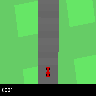

In [5]:
env = gym.make("CarRacing-v0")
env = wrap_env(env)
env.reset()
for _ in range(50):
     observation, _,_,_ = env.step([0,0,0])
px.imshow(observation)

In [6]:
env.observation_space

Box(0, 255, (96, 96, 3), uint8)

In [7]:
env.action_space

Box(-1.0, 1.0, (3,), float32)

In [8]:
env.action_space.sample()

array([0.47960177, 0.0706716 , 0.72345126], dtype=float32)

In [9]:
env.close()

In [10]:
def run_racing(policy, max_steps=1000):
    env = gym.make("CarRacing-v0")
    env = wrap_env(env)
    obs = env.reset() # Intialize the observation
    for step in tqdm(range(min(max_steps, 1000))):
        env.render()

        move = policy(obs, env, step) # create a move using the policy
        obs, reward, done, info = env.step(move) # advance the environment using the move
        if done: # if the environment comes to an end, break out of loop
          break

    env.close()
    show_video()

In [11]:
def mystery_policy_1(obs, env, ts):
    return [0,1,0] # the vehicle keeps accelerating

In [12]:
run_racing(mystery_policy_1, 200)

Track generation: 1063..1333 -> 270-tiles track


  0%|          | 0/200 [00:00<?, ?it/s]

In [13]:
def left_policy(obs, env, ts):
    if ts % 2 == 1: # if the time is odd, want to turn left
      return [-1,0,0]
    else:
      return [0,1,0] # if time is even, accelerate straight ahead
run_racing(left_policy, 200)

Track generation: 1106..1395 -> 289-tiles track


  0%|          | 0/200 [00:00<?, ?it/s]

In [14]:
def random_policy(obs, env, ts):
    return env.action_space.sample()
run_racing(random_policy, 200)

Track generation: 1048..1318 -> 270-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1151..1443 -> 292-tiles track


  0%|          | 0/200 [00:00<?, ?it/s]

Track generation: 1109..1398 -> 289-tiles track



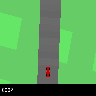

In [15]:
env = gym.make("CarRacing-v0")
env.reset()
for _ in range(50):
     observation, _,_,_ = env.step([0,0,0])
env.close()
px.imshow(observation)
# print(observation[0][0])

In [16]:
print(len(observation[0]))

96


In [17]:
def is_road(img, r, c):
    return all(102 <= i <= 107 for i in img[r,c,:]) # returns true if all color values of a specific pixel fall in the range


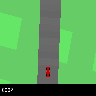

In [18]:
def road_pixels(img):
    road = np.zeros((96,96))
    for r in range(96):
        for c in range(96):
            road[r, c] = is_road(img, r, c)
    return road

obs_road = road_pixels(observation)
fig = make_subplots(rows=1, cols=2, shared_yaxes=True)
fig.add_trace(px.imshow(observation).data[0], 1, 1)
fig.add_trace(px.imshow(obs_road).data[0], 1,2)
fig.show()

In [19]:
def front_is_road(img):
   return any(is_road(img, 50, i) for i in range(38, 56))
  # the car is stationary at x = 50, so between columns 38 and 55, if any of the pixels are part of the road, return true, else false

def go_until_front_is_not_road(obs, env, step):
        if step < 40:
            return [0,0,0] # completely stopped
        if front_is_road(obs):
            return [0,1,0] # accelerate
        else:
            return [0,0,1] # brake
        
run_racing(go_until_front_is_not_road, 300)

Track generation: 1223..1533 -> 310-tiles track


  0%|          | 0/300 [00:00<?, ?it/s]

In [20]:
def is_left_turn(img):
    road = road_pixels(img)
    left_half = road[:,:48]
    right_half = road[:,48:]
    return np.mean(left_half) > np.mean(right_half) # if there are more pixels on left side of road, return true, else false
    # assuming we're trying to turn left, we need more road to be on the left than the right


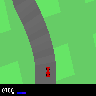

I predict that this is a left turn!



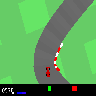

I predict that this is a right turn!


In [21]:
imgs, _, labels = load_pkl('gathered.pkl')
px.imshow(imgs[6]).show()
if is_left_turn(imgs[6]):
    print("I predict that this is a left turn!")
else:
    print("I predict that this is a right turn!")
    
px.imshow(imgs[24]).show()
if is_left_turn(imgs[24]):
    print("I predict that this is a left turn!")
else:
    print("I predict that this is a right turn!")

In [22]:
env = gym.make("CarRacing-v0")
NEUTRAL = [0,0,0]
RIGHT = [1,0,0]
LEFT = [-0.75, 0, 0.5]
ACCEL = [0,0.6,0]
BREAK = [0,0,1]

class Driver:
    def __init__(self):
        self.mode = ['accel', 'left', 'break']

    def drive(self, obs, env, ts):
        if ts < 40:
            return NEUTRAL
        
        if front_is_road(obs):
            self.mode = 'accel'
            return ACCEL
        elif not front_is_road(obs) and is_left_turn(obs):
          self.mode = 'left'
          return LEFT

        
run_racing(Driver().drive, max_steps=200 )

Track generation: 1187..1488 -> 301-tiles track


  0%|          | 0/200 [00:00<?, ?it/s]